In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import uuid
import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout
from tensorflow import Tensor, concat
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import accuracy_score

RANDOM_SEED = 42

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/skin cancer/Melanoma_Cancer_Image_Dataset/test"
train_ds, val_ds = image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  image_size=(64, 64),
  subset="both",
  seed=RANDOM_SEED,
  pad_to_aspect_ratio=True,
  shuffle=True,
  batch_size=32)
train_ds

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
class_names: list[str] = train_ds.class_names
print(class_names)

['Benign', 'Malignant']


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [ ]:
num_classes = 2

model = Sequential([
    Input(shape=(64, 64, 3)),
    Rescaling(1./255),

    Conv2D(16, (4,4), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (2,2), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Conv2D(128, (2,2), activation='relu'),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 61, 61, 16)     │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,570 (982.70 KB)

 Trainable params: 251,570 (982.70 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy', # log loss
  metrics=['accuracy'] # extra every epoch
)

In [ ]:
es = EarlyStopping(
    monitor="val_loss",
    patience=5, #how many consecutive epochs
    verbose=1,
    restore_best_weights=True
)
es

In [ ]:
EPOCHS = 30

history: History = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS, callbacks = [es], verbose = 1
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 218s 4s/step - accuracy: 0.5447 - loss: 0.6938 - val_accuracy: 0.7225 - val_loss: 0.6810
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.6700 - loss: 0.6537 - val_accuracy: 0.7425 - val_loss: 0.5233
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.7184 - loss: 0.5468 - val_accuracy: 0.6575 - val_loss: 0.5914
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.8009 - loss: 0.4316 - val_accuracy: 0.8225 - val_loss: 0.3848
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.8290 - loss: 0.3817 - val_accuracy: 0.8975 - val_loss: 0.3038
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.8351 - loss: 0.3813 - val_accuracy: 0.8900 - val_loss: 0.2705
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.8642 - loss: 0.3106 - val_accuracy: 0.8800 - val_loss: 0.2736
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.8662 - loss: 0.3041 - val_accuracy: 

In [ ]:
os.makedirs("models", exist_ok=True)

save_model(model, "models/sequential.keras")

In [ ]:
malignant_index = class_names.index("Malignant")
print(class_names)
y_pred_prob = model.predict(val_ds)
y_pred = np.argmax(y_pred_prob, axis=1)
y_malignant_prob = y_pred_prob[:, malignant_index]
threshold = 0.4   #we can change the threshold to improve the recall

y_pred = (y_malignant_prob >= threshold).astype(int)

['Benign', 'Malignant']
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
y_true = np.concatenate([y.numpy() for _, y in val_ds])

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

Precision: 0.9156680946552427
Recall: 0.944954128440367
              precision    recall  f1-score   support

      Benign       0.93      0.88      0.90       182
   Malignant       0.90      0.94      0.92       218

    accuracy                           0.92       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.92      0.92      0.91       400



In [ ]:
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.optimizers import Adam

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))
vgg_base.trainable = False  # freeze pre-trained layers

vgg_model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

vgg_model.compile(optimizer=Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
vgg_model.summary()

history_vgg = vgg_model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[es])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,239,746 (58.14 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6705 - loss: 4.5216 - val_accuracy: 0.8750 - val_loss: 1.3834
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8395 - loss: 1.6961 - val_accuracy: 0.9000 - val_loss: 1.0422
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8534 - loss: 1.2571 - val_accuracy: 0.9150 - val_loss: 0.9658
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9022 - loss: 0.7819 - val_accuracy: 0.9150 - val_loss: 0.8926
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9319 - loss: 0.6246 - val_accuracy: 0.9075 - val_loss: 0.9249
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9185 - loss: 0.5969 - val_accuracy: 0.9100 - val_loss: 0.8400
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9205 - loss: 0.5309 - val_accuracy: 0.9025 - val_loss: 0.8401
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9422 - loss: 0.3163 - val_accuracy: 0.9025 - val_loss:

In [ ]:
vgg_model.save("models/vgg_model.keras")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (64, 64)
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/skin cancer/Melanoma_Cancer_Image_Dataset/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 12304 images belonging to 2 classes.


In [ ]:
malignant_index = class_names.index("Malignant")
print(class_names)
y_pred_prob = vgg_model.predict(val_ds)
y_pred = np.argmax(y_pred_prob, axis=1)
y_malignant_prob = y_pred_prob[:, malignant_index]
threshold = 0.4   #we can change the threshold to improve the recall

y_pred = (y_malignant_prob >= threshold).astype(int)

['Benign', 'Malignant']
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
y_true = np.concatenate([y.numpy() for _, y in val_ds])

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

Precision: 0.9174730694518024
Recall: 0.926605504587156
              precision    recall  f1-score   support

      Benign       0.91      0.91      0.91       182
   Malignant       0.92      0.93      0.92       218

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



In [ ]:
effnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64,64,3))
effnet_base.trainable = False

effnet_model = Sequential([
    effnet_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

effnet_model.compile(optimizer=Adam(1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
effnet_model.summary()

history_effnet = effnet_model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[es])
effnet_model.save("models/effnet_model.keras")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 2, 2, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,310,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,361,061 (20.45 MB)

 Trainable params: 1,311,490 (5.00 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 265ms/step - accuracy: 0.7024 - loss: 0.5368 - val_accuracy: 0.8950 - val_loss: 0.2944
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.8869 - loss: 0.3024 - val_accuracy: 0.9050 - val_loss: 0.2590
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.9008 - loss: 0.2524 - val_accuracy: 0.9150 - val_loss: 0.2429
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - accuracy: 0.9069 - loss: 0.2298 - val_accuracy: 0.9075 - val_loss: 0.2314
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.9155 - loss: 0.2092 - val_accuracy: 0.9125 - val_loss: 0.2226
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.9295 - loss: 0.1902 - val_accuracy: 0.9125 - val_loss: 0.2242
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.9352 - loss: 0.1851 - val_accuracy: 0.9200 - val_loss: 0.2126
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 235ms/step - accuracy: 0.9512 - loss: 0.1477 - val_accu

In [ ]:
effnet_model.save("models/effnet_model.keras")

In [ ]:
malignant_index = class_names.index("Malignant")
print(class_names)
y_pred_prob = effnet_model.predict(val_ds)
y_pred = np.argmax(y_pred_prob, axis=1)
y_malignant_prob = y_pred_prob[:, malignant_index]
threshold = 0.4   #we can change the threshold to improve the recall

y_pred = (y_malignant_prob >= threshold).astype(int)

['Benign', 'Malignant']
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
y_true = np.concatenate([y.numpy() for _, y in val_ds])

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

Precision: 0.9304434950666259
Recall: 0.9541284403669725
              precision    recall  f1-score   support

      Benign       0.94      0.90      0.92       182
   Malignant       0.92      0.95      0.94       218

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



In [ ]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


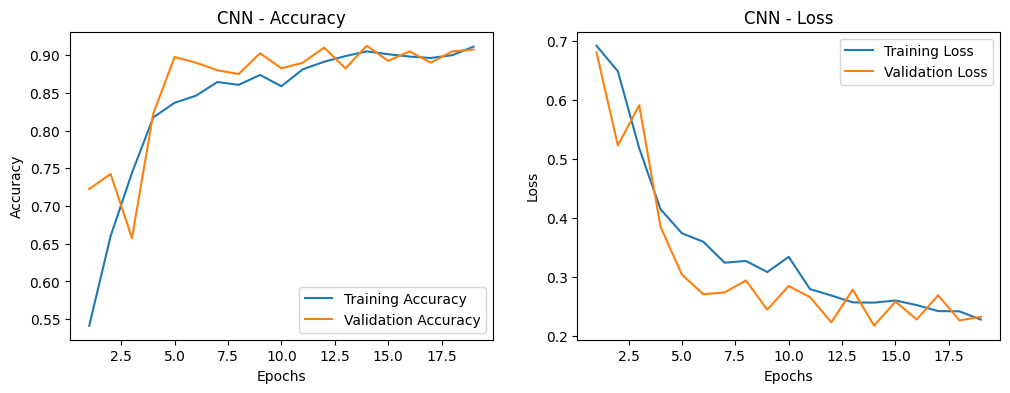

In [ ]:
plot_history(history, "CNN")


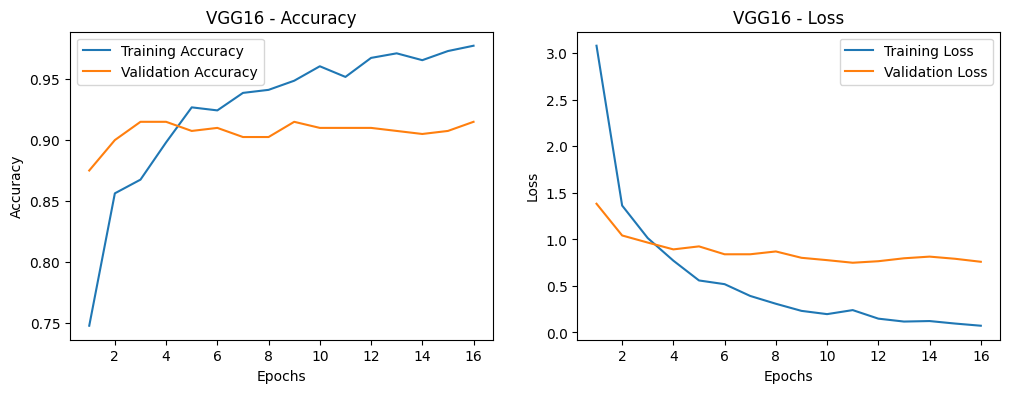

In [ ]:
plot_history(history_vgg, "VGG16")


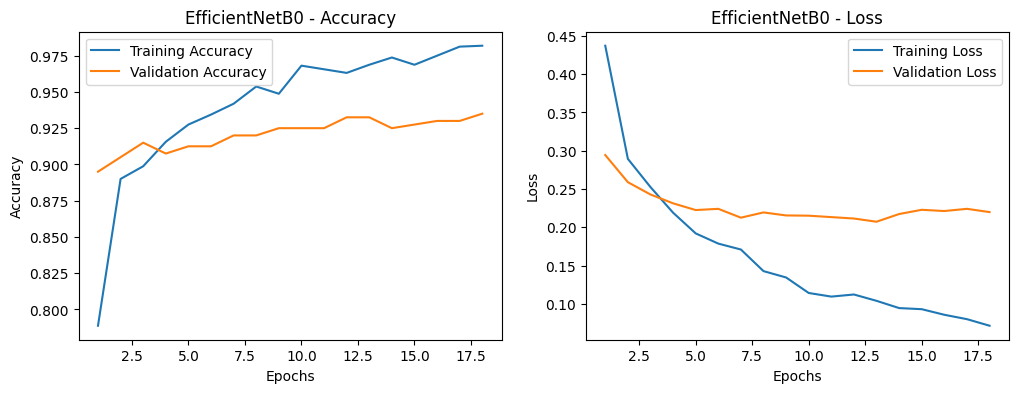

In [ ]:
plot_history(history_effnet, "EfficientNetB0")


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()


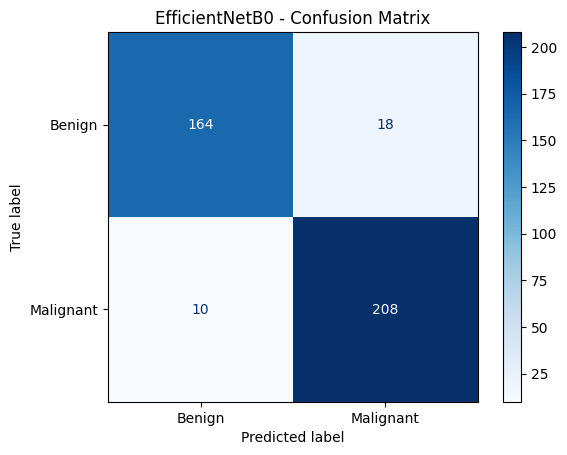

In [ ]:
plot_conf_matrix(y_true, y_pred, "EfficientNetB0")


Based on accuracy, loss stability, and generalization across datasets, EfficientNetB0 was selected as the final model

In [6]:
!pip install -q streamlit tensorflow pillow
!apt-get install -y nodejs npm > /dev/null
!curl -LO https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 110.7 MB/s eta 0:00:00
Extracting templates from packages: 100%
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 19.1M  100 19.1M    0     0  22.8M      0 --:--:-- --:--:-- --:--:-- 22.8M
Selecting previously unselected package cloudflared.
(Reading database ... 125098 files and directories currently installed.)
Preparing to unpack cloudflared-linux-amd64.deb ...
Unpacking cloudflared (2026.1.1) ...
Setting up cloudflared (2026.1.1) ...
Processing triggers for man-db (2.10.2-1) ...


In [2]:
%%writefile app.py
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

# ---------------- CONFIG ----------------
IMG_SIZE = (64, 64)
MODEL_PATH = "/content/models/effnet_model.keras"  # Path to your trained model

st.set_page_config(
    page_title="Skin Cancer Detection",
    page_icon="🧬",
    layout="centered"
)

# ---------------- LOAD MODEL ----------------
@st.cache_resource
def load_dl_model():
    return load_model(MODEL_PATH)

model = load_dl_model()

# ---------------- UI ----------------
st.title(" Skin Cancer Detection")
st.write("Upload a skin lesion image to classify it as Benign or Malignant")

threshold = st.slider(
    "Malignancy Threshold",
    min_value=0.1,
    max_value=0.9,
    value=0.5,
    step=0.05
)

uploaded_file = st.file_uploader(
    "Upload image",
    type=["jpg", "jpeg", "png"]
)

# ---------------- PREDICTION ----------------
if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_container_width=True)

    img = image.resize(IMG_SIZE)
    x = np.expand_dims(np.array(img), axis=0)
    x = preprocess_input(x)

    prob = model.predict(x)[0][1]  # index 1 = Malignant
    if prob >= threshold:
        st.error(f"Malignant (Confidence: {prob:.2%})")
    else:
        st.success(f"Benign (Confidence: {(1 - prob):.2%})")

    st.progress(float(prob))

st.caption("For research & educational purposes only. Not a medical diagnosis.")


Writing app.py


In [3]:
import os, time

os.system("nohup streamlit run app.py --server.port 8501 --server.address 0.0.0.0 &")
time.sleep(5)


In [5]:
!cloudflared tunnel --url http://localhost:8501


/bin/bash: line 1: cloudflared: command not found
